In [1]:
from io import StringIO

import matplotlib.pyplot as plt
from scipy.io import arff
import seaborn as sns
from loguru import logger
import yaml

from datetime import datetime
import polars as pl
import pandas as pd
import numpy as np
import sys
import os
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

# MODEL
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import (
    LabelEncoder, 
    StandardScaler,
    label_binarize
)
from sklearn.metrics import (
    classification_report, 
    confusion_matrix, 
    accuracy_score,
    precision_recall_fscore_support,
    balanced_accuracy_score,
    roc_auc_score,
    roc_curve
)

# Save variables for model
import joblib

# PERSONAL FUNCTIONS
from utils import *
from models.main import *
from functions.windows import create_feature_windows # creación de ventanas e ingenieria de características

In [2]:
df_accel = pl.read_csv(r"F:\UPC\Tesis\HARbit-Model\src\test\data\Watch_accelerometer.csv")
df_gyro = pl.read_csv(r"F:\UPC\Tesis\HARbit-Model\src\test\data\Watch_gyroscope.csv")

In [3]:
df_accel = normalize_columns(df_accel, 
                            user_col_name  = "User", 
                            timestamp_col_name = "Creation_Time", 
                            label_col_name = "gt", 
                            x_col_name = "x", 
                            y_col_name = "y", 
                            z_col_name = "z")

df_gyro = normalize_columns(df_gyro, 
                            user_col_name  = "User", 
                            timestamp_col_name = "Creation_Time", 
                            label_col_name = "gt", 
                            x_col_name = "x", 
                            y_col_name = "y", 
                            z_col_name = "z")

In [4]:
df_accel = convert_timestamp(df_accel)
df_gyro = convert_timestamp(df_gyro)

In [5]:
df_all_sensors = df_gyro.join(df_accel, on = ['Subject-id', 'Timestamp', 'Activity Label'], how = "inner")

In [6]:
df_gyro_group = convert_frequences(df_gyro, hz = 20)
df_accel_group = convert_frequences(df_accel, hz = 20)

🔄 Convirtiendo a 20Hz (ventanas de 50ms)
📊 Procesando usuario 1/9: c
  🎯 Actividad: sit (66408 muestras)
    ✅ 66408 → 7145 muestras
  🎯 Actividad: stairsdown (66792 muestras)
    ✅ 66792 → 7389 muestras
  🎯 Actividad: stairsup (65185 muestras)
    ✅ 65185 → 7349 muestras
  🎯 Actividad: stand (71943 muestras)
    ✅ 71943 → 7690 muestras
  🎯 Actividad: null (59391 muestras)
    ✅ 59391 → 7242 muestras
  🎯 Actividad: bike (76778 muestras)
    ✅ 76778 → 8256 muestras
  🎯 Actividad: walk (71964 muestras)
    ✅ 71964 → 7821 muestras
📊 Procesando usuario 2/9: i
  🎯 Actividad: stairsdown (10236 muestras)
    ✅ 10236 → 1022 muestras
  🎯 Actividad: bike (4684 muestras)
    ✅ 4684 → 472 muestras
  🎯 Actividad: walk (1833 muestras)
    ✅ 1833 → 185 muestras
  🎯 Actividad: null (9636 muestras)
    ✅ 9636 → 970 muestras
  🎯 Actividad: stairsup (12851 muestras)
    ✅ 12851 → 1284 muestras
  🎯 Actividad: sit (2901 muestras)
    ✅ 2901 → 295 muestras
  🎯 Actividad: stand (1562 muestras)
    ✅ 1562 → 1

In [7]:
features_gyro   = create_feature_windows(df_gyro_group, window_seconds = 5, overlap_percent=50, sampling_rate = 20)
features_accel  = create_feature_windows(df_accel_group, window_seconds = 5, overlap_percent=50, sampling_rate = 20)

In [47]:
features_combined = pd.merge(
    features_gyro,
    features_accel, 
    on=['Subject-id', 'Activity Label', 'window_start', 'window_end', 'sample_count'], 
    how="inner"
)

In [48]:
activities_dict = {
    'Walk': ['walk', 'stairsup', 'stairsdown'],
    'Stand': ['stand'],
    'Sit': ['sit'],
    'Others': ['null', 'bike']
}

for activity in activities_dict.keys():
    for old_activity in activities_dict[activity]:
        features_combined.loc[features_combined['Activity Label'] == old_activity, 'Activity Label'] = activity

In [49]:
features_combined = features_combined[features_combined['Activity Label'] != 'Others']

In [28]:
aux_dict = {
    'A': 'Walk',
    'C': 'Stairs',
    'E': 'Stand',
    'D': 'Sit'
}

for activity in aux_dict.keys():
    features_combined.loc[features_combined['Activity Label'] == aux_dict[activity], 'Activity Label'] = activity

In [56]:
X, y, subjects, le = prepare_features_for_cnn_lstm_sequences(
    features_combined, 
    group_size=8, 
    step_size=1
)

print(f"Forma de X (secuencias): {X.shape}")   # (N, group_size, features)
print(f"Forma de y: {y.shape}")
print(f"Actividades únicas: {np.unique(y)}")

✅ Secuencias creadas: (4047, 8, 136)
  Num features: 136
  Clases: ['Sit' 'Stand' 'Walk']
Forma de X (secuencias): (4047, 8, 136)
Forma de y: (4047,)
Actividades únicas: [0 1 2]


In [57]:
y = le.inverse_transform(y)

In [ ]:
from tensorflow import keras

model = keras.models.load_model(r'F:\UPC\Tesis\HARbit-Model\src\models\cnn-lstm_har_model_98_cluster.h5')
label_encoder = joblib.load(r'F:\UPC\Tesis\HARbit-Model\src\models\meta\label_encoder_cnn_lstm_98_cluster.joblib')

In [58]:
y = label_encoder.transform(y)

Evaluando modelo...
127/127 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
✅ Accuracy filtrado (solo clases presentes en el dataset): 0.6064

Pérdida en test: 4.0201
Precisión en test: 0.6064

REPORTE DE CLASIFICACIÓN
              precision    recall  f1-score   support

         Sit     0.9468    0.4967    0.6516       753
       Stand     0.9970    0.4573    0.6270       737
        Walk     1.0000    0.6817    0.8107      2557

   micro avg     0.9911    0.6064    0.7524      4047
   macro avg     0.9813    0.5452    0.6964      4047
weighted avg     0.9896    0.6064    0.7476      4047



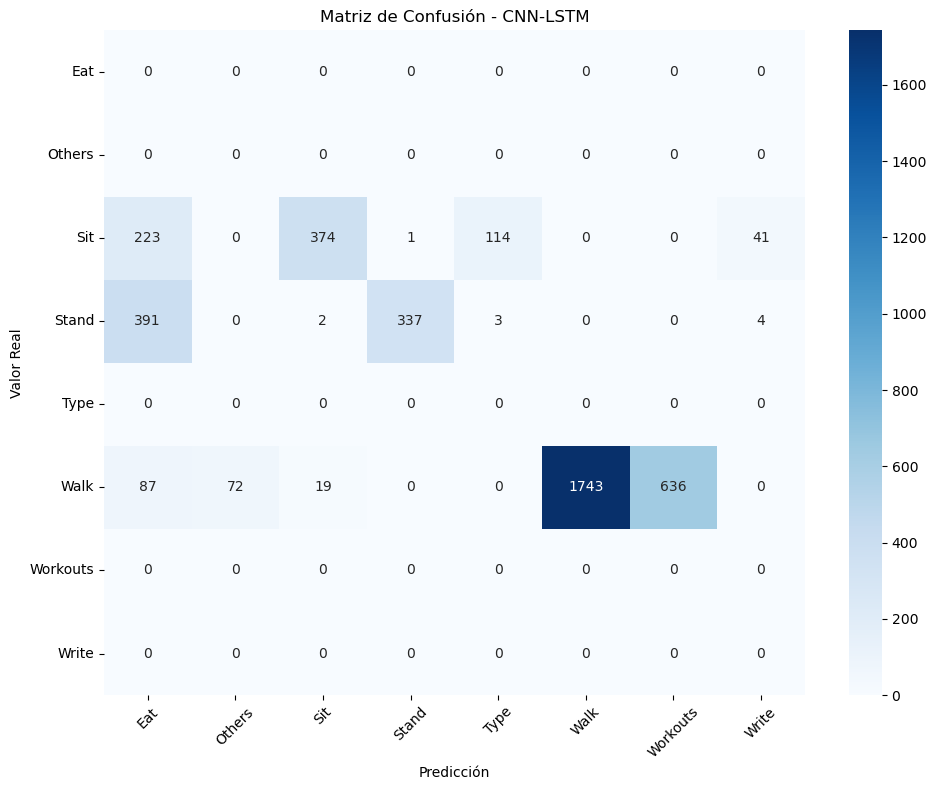

In [60]:
print("Evaluando modelo...")
# Predicciones
y_pred = model.predict(X)
y_pred_classes = np.argmax(y_pred, axis=1)

# Obtener las clases que realmente existen en este conjunto de datos
unique_classes = np.unique(y)

# Calcular accuracy SOLO en esas clases
mask = np.isin(y, unique_classes)
filtered_accuracy = accuracy_score(y[mask], y_pred_classes[mask])

print(f"✅ Accuracy filtrado (solo clases presentes en el dataset): {filtered_accuracy:.4f}")


# Métricas básicas
test_loss, test_accuracy = model.evaluate(X, y, verbose=0)
print(f"\nPérdida en test: {test_loss:.4f}")
print(f"Precisión en test: {test_accuracy:.4f}")

# Reporte de clasificación detallado
print("\n" + "="*50)
print("REPORTE DE CLASIFICACIÓN")
print("="*50)
print(classification_report(
    y, 
    y_pred_classes, 
    labels=unique_classes,               # solo las clases presentes
    target_names=label_encoder.classes_[unique_classes],
    digits=4
))

# Matriz de confusión
cm = confusion_matrix(y, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=label_encoder.classes_,
    yticklabels=label_encoder.classes_
)
plt.title('Matriz de Confusión - CNN-LSTM')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()